# Big Data Tests

## Description of the problem
Taking in consideration a fixed geographic area composed of the italian regions of Trentino, Lombardia and Veneto and dividing this area into a fixed grid of size 4x4 we are interested in computing the topic for each cell in the grid and use the obtained results to compute the topic of the cell of a new grid 2x2. 

In this jupyter notebook we are going to test the methods described in the paper and we will compare the results with respect to the baseline method which consists in recomputing the LDA model for each cell of the new grid.

In [1]:
import copy
import pymongo
import time
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import math
from lib.lda import LDAHelper
import json
import shapely
import pickle
%matplotlib inline

# Spark Requirements
import findspark
import random

# Istantiate the helper object
# LDAHelper is a class that contains helper methods
# to compute LDA models and to use the gensim library

n_topics = 15
lda_helper = LDAHelper(disableLogs=True, ntopics=n_topics)

# connect db
client = pymongo.MongoClient('localhost', 27017)

# get db
db = client['url-project']

# open collection
documents = db['documents']

## Function definitions

In [2]:
def get_texts_from_db(mongo_collection, geometry_geojson):
    """
    Returns a list of strings that represents the texts of the documents in the specified area *geometry_geojson*.
    Input: mongo_collection, geojson object of the area
    """
    results = mongo_collection.find({
        'loc': {'$geoWithin': {'$geometry': geometry_geojson}}
    })

    texts = []
    for result in results:
        texts.append(result['boilerpipe'])

    return texts

In [3]:
def create_grid(x_squares, y_squares, geo_map):
    """
    Returns a GeoDataFrame with all the polygons which define
    a grid with x_squares and y_squares over the geomap.
    """
    boundaries = dict({'min_x':gps.total_bounds[0],'min_y':gps.total_bounds[1],
                       'max_x':gps.total_bounds[2],'max_y':gps.total_bounds[3]})
    
    dim_x = (boundaries['max_x'] - boundaries['min_x']) / x_squares
    dim_y = (boundaries['max_y'] - boundaries['min_y']) / y_squares
    
    # Divide the map into cells
    polygons = []

    for i in range(0,x_squares):
        # start from the min_x, and increment it
        # x1 is the bottom x of the square, x2 the top
        x1 = boundaries['min_x'] + (dim_x * i)
        x2 = boundaries['min_x'] + (dim_x * (i+1))

        for j in range(0,y_squares):
            # decrement max_y, get y1 and y2
            y1 = boundaries['max_y'] - (dim_y*j)
            y2 = boundaries['max_y'] - (dim_y* (j+1))
            polygon_desc = {}

            # Create shape (polygon)
            p = Polygon([(x1,y1),(x2,y1),(x2,y2),(x1,y2)])

            # Save the shape and indexes into a polygon_desc object
            # and append the object into polygons list
            polygon_desc['id_x'] = i # col -> x
            polygon_desc['id_y'] = j # row -> y
            polygon_desc['geometry'] = p
            polygons.append(polygon_desc)

    # Create the geoDataFrame and save it into the file
    return gpd.GeoDataFrame(polygons)
    

In [4]:
def compute_model_entire_map(grid):
    """
    Compute the LDA model over the entire grid,
    useful to extract all the possible topics.
    """
    all_texts = []
    for cell in grid:
        all_texts += cell['texts']

    lda_results = lda_helper.lda_topic(all_texts, dictionary=dictionary, dictionary_filters=False)
    return lda_results

## From GeoJSON to the creation of the minimum grid
All the methods require the definition of a minimum grid; for semplicity we consider a minimum grid of sizes **4x4**.

To create the grid:
1. Get a geographic area from GeoJSON file
2. Call the functions **create_grid** that create a matrix of dimension **4x4**

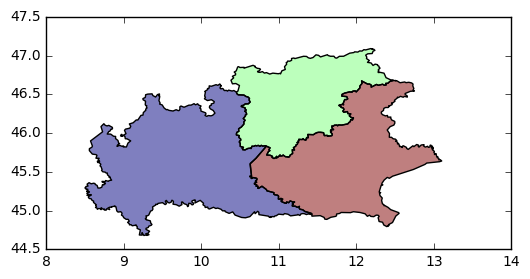

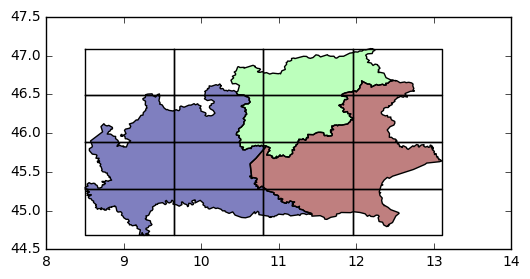

In [8]:
# Import a GeoJSON file in which are defined the regions
nord_map = gpd.read_file("data/nord.json")

# Plot
nord_map.head()
nord_map.plot()

# Greate a GeoSeries from the map
gps = gpd.GeoSeries(nord_map.geometry)

# fix the number of squares
x_squares = 4
y_squares = 4

# Create the minimum grid
gdf = create_grid(x_squares, y_squares, gps)

# Plot the map and the grid
base = gdf.plot(color='white')
nord_map.plot(ax=base);

## Add texts and information to each cell

For each cell, then retrieve from the database the documents in the corresponding geographic area.

    Grid is a vector of cells. Each cells is a python dictionary that contains the following fields:
    - polygon: the geometry of the cell
    - doc_area: the geometry of the area that intersect the cell
    - id_x: column index
    - id_y: row index
    - texts: tokenized set of documents in doc_area

At the end, the object **gensim.Dictionary** is created. We are now ready to run the baseline approach and compute the lda model for each cell of the minimum grid.

In [9]:
# Define the grid
grid = []

# merge polygon of the map
marged_area = nord_map
marged_area = gpd.GeoSeries(shapely.ops.cascaded_union(marged_area.geometry.tolist()))

all_texts = []
for index, value in gdf.iterrows():
    cell = {}
    cell["polygon"] = value.geometry
    cell["id_x"] = value.id_x
    cell["id_y"] = value.id_y
    
    # square contains also area that does not appear in the north map of the italy
    # to retrieve only the document inside the map, we have to do the intersection
    # between the cell's polygon and map, the result is in the variable doc_area
    doc_area = (marged_area.intersection(cell["polygon"])).tolist()[0]
    cell["doc_area"] = doc_area
    
    #  === to visualize the intersection between the map and the cell
    # base = (marged_area.intersection(cell["polygon"])).plot(color='white')
    # nord_map.plot(ax=base);
    
    # get docs from db
    docs = get_texts_from_db(documents, shapely.geometry.mapping(doc_area))
    
    # Tokenize documents
    # Convert the document into bag of words
    # Tokenization + Stop Words removal
    texts = []
    for doc in docs:
        texts.append(lda_helper.clean(doc))
    
    # Save documents
    cell["texts"] = texts

    # merge tokenized documents to the set of all documents
    all_texts += texts
    
    # save the cell into the grid list
    grid.append(cell)
    
# Now that we have all the texts, we can create the dictionary that
# we are going to use from now on
dictionary = lda_helper.create_dictionary(all_texts)
print("total number of documents ", len(all_texts))

total number of documents  20988


In [11]:
# Save dictionary
with open('data/dictionary.pkl', 'wb') as f:
    pickle.dump(dictionary, f, protocol=0)

## Compute LDA entire map
Compute the LDA model for the entire map in order to extract 15 topics that holds for all the map.

In [7]:
lda_results = compute_model_entire_map(grid)
lda_map = lda_results['lda_model']

In [8]:
# Since it is a computational heavy task, save the result in the object *lda_map*
with open('data/lda_map.pkl', 'wb') as f:
    pickle.dump(lda_map, f)

# To retrieve back the object
with open('data/lda_map.pkl', 'rb') as f:
    lda_map = pickle.load(f)

## Compute topic for the minimum grid

Computing the baseline for the minimal grid is the base step for all the other methods.

In [ ]:
for cell in grid:
    # get tokenized documents
    texts = cell['texts']

    print("computing lda for...", "col", cell["id_x"], "row", cell["id_y"], len(texts))
    
    # compute lda model
    lda_results = lda_helper.lda_topic(texts, dictionary=dictionary, dictionary_filters=False)

    # get lda results: model, topics and corpus (doc2bow)
    cell['lda_model'] = lda_results['lda_model']
    cell['topics'] = lda_results['topics']
    cell['corpus'] = lda_results['corpus']

In [9]:
# save the lda model for the minimal grid 
with open('data/nordgrid.pkl', 'wb') as f:
    pickle.dump(grid, f)

# load pre-computated minimal-grid 4x4
with open('data/nordgrid.pkl', 'rb') as f:
    minimalgrid = pickle.load(f)

## Change Grid size

The idea is that we can reduce the size of the preeceding grid by a factor of two. Since we start from the minimum and finest grid 4x4, the new grid will be of size 2x2. In that way, we have that a new cell is composed of 4 cells of the previous grid. To avoid recomputation, the idea is to use the results of these 4 cells to compute the topics that hold for the new resulting cell.

new cell 0 0 contains old cell 0 0
new cell 0 0 contains old cell 0 1
new cell 0 0 contains old cell 1 0
new cell 0 0 contains old cell 1 1
new cell 0 1 contains old cell 0 2
new cell 0 1 contains old cell 0 3
new cell 0 1 contains old cell 1 2
new cell 0 1 contains old cell 1 3
new cell 1 0 contains old cell 2 0
new cell 1 0 contains old cell 2 1
new cell 1 0 contains old cell 3 0
new cell 1 0 contains old cell 3 1
new cell 1 1 contains old cell 2 2
new cell 1 1 contains old cell 2 3
new cell 1 1 contains old cell 3 2
new cell 1 1 contains old cell 3 3


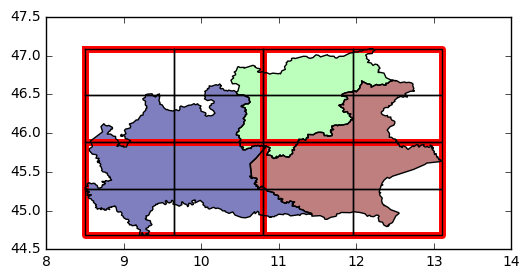

In [10]:
# minimalgrid 4x4 -> grid 2x2
preceed_grid = minimalgrid
preceed_dimension = 4
target_dimension = int(preceed_dimension / 2)

# Create a new grid for the map gps with dimension 2
new_grid_gdf = create_grid(target_dimension, target_dimension, gps)

# Plot
new_base = new_grid_gdf.plot(color='white', edgecolor="red", linewidth=5)
base = gdf.plot(ax=new_base, color='white')
nord_map.plot(ax=base)

# Add information to the new grid such as the contained cell of the previous grid
new_grid = []
for index, value in new_grid_gdf.iterrows():
    cell = {}
    cell["polygon"] = value.geometry
    cell["id_x"] = value.id_x
    cell["id_y"] = value.id_y
    cell["texts"] = []
    cell["parts"] = []
    
    for c in preceed_grid:
        if cell["polygon"].contains(c["polygon"]):
            cell["texts"] += c["texts"]
            cell["parts"].append(c)
            print("new cell", cell["id_x"], cell["id_y"], "contains old cell", c["id_x"], c["id_y"])
    
    new_grid.append(cell)


## Extract Topic for the new Grid
### Baseline method

We are now interested in computing the topic for each cell of the new grid. As we did before for the minimum grid, one way extract the topic is compute a LDA model using all the documents in the contained cells. This method does not use the result of the previous computation and is computationally expensive.

In [ ]:
# def compute_baseline(grid): 
    for cell in grid:
        texts = cell["texts"]
        print("computing lda for", len(texts), "documents")
        
        # compute lda model
        lda_results = lda_helper.lda_topic(texts, dictionary=dictionary, dictionary_filters=False)

        cell['corpus'] = lda_results['corpus']
        cell['lda_model'] = lda_results['lda_model']
        cell['topics'] = lda_results['topics']


# hardcopy the newgrid into the new_baseline_grid
new_baseline_grid = copy.deepcopy(new_grid)
start_time = time.time()

# computes lda models
compute_baseline(new_baseline_grid)

# take the time
print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
# save the result of the computation above
with open('data/new_grid_baseline.pkl', 'wb') as f:
    pickle.dump(new_baseline_grid, f)

# load pre-computated minimal-grid 4x4
with open('data/new_grid_baseline.pkl', 'rb') as f:
    new_baseline_grid = pickle.load(f)

### Avoid Recomputations

#### Top Topic Aggregation

The idea is to pre-compute once the LDA model of the entire map, asking for a large number
of topics. Then calculate the top topic distributions of the corpus of each subcell with respect to the topics extracted from the entire map and then, merge the resulting distibution together.

In [ ]:
def top_topic_aggregation(grid, lda_map):
    for cell in grid:
        parts = cell['parts']
        corpus_list = []
        for p in parts:
            if len(p['corpus']) > 0:
                corpus_list.append(p['corpus'])
        top_topics = lda_helper.lda_toptopic_merge(lda_map, corpus_list)
        cell['topics'] = top_topics

times = []
grid_toptopic_aggregation = copy.deepcopy(new_grid)

for i in range(5):
    start_time = time.time()
    top_topic_aggregation(grid_toptopic_aggregation, lda_map)
    times.append(time.time() - start_time)
print("--- %s seconds ---" % np.mean(times))

# Big data analysis
The tool *spark* is used in order to parallelize the top topic evaluation and aggregation inside each cells.

In [15]:
with open('data/input_1_new_grid.pkl', 'wb') as f:
    pickle.dump(new_grid, f)
    
with open('data/input_2_lda_map.pkl', 'wb') as f:
    pickle.dump(lda_map, f)

In [14]:
import findspark
findspark.init()
print("spark path:", findspark.find())

from pyspark import SparkConf, SparkContext
import pprint

try:
    sc.stop()
except:
    pass

#sc = SparkContext('local', 'test')
sc = SparkContext('local[4]', appName='test')

spark_grid = []
counter = 0
for cell in new_grid:
    cell_id = counter
    for p in cell['parts']:
        fake_corpus = p['corpus']
        tup = (cell_id, fake_corpus)
        spark_grid.append(tup)
    counter += 1

lda_map_broadcast = sc.broadcast(lda_map)

times = []
for i in range(5):
# So the first thing that we have to do is convert a list in a RDD
    start_time = time.time()
    rdd_grid = sc.parallelize(spark_grid, 4)
    topics = rdd_grid.map(lambda scell: (scell[0], lda_helper.calculate_topic_distributions(lda_map_broadcast.value, scell[1])))
    topics = topics.reduceByKey(lambda a, b: lda_helper.merge_toptopic(a, b))
    topics = topics.sortByKey(True)
    spark_result = topics.collect()
    spark_result = list(zip(*spark_result))[1]
    spark_result = list(spark_result)
    times.append(time.time() - start_time)
    topics.unpersist()
    del topics
    

print("--- %s seconds ---" % np.mean(times))

spark path: /home/hado/spark
--- 50.1223469734 seconds ---
